# QC methods
load the predictions for the validation model for each.

and compute the confusion matrix, the precision and f1 score (multiclass)
and roc curve maybe? what curves do we use for multiclass.


In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets_v2.mri_dataset_inram import MRISegmentation3DDataset
from twaidata.torchdatasets_v2.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaidata.mri_dataset_directory_parsers.MSS3_multirater import MSS3MultiRaterDataParser

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy

In [3]:
import proplot as pplt

In [4]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Loading the Fazekas Categories

In [5]:
from trustworthai.journal_run.new_MIA_fazekas_and_QC.dataset_setup import *

In [6]:
cvd_data, adni_data, challenge_data = load_spreadsheets()

challenge shapes before and after cleanup
(175, 1532)
(175, 1465)
cvd shapes before and after cleanup
(250, 1552)
(250, 1402)
adni shapes before and after cleanup
(299, 1544)
(299, 1374)


### Load and preprocess the per-sample features

In [7]:
adni_spreadsheet_folder = "/home/s2208943/mounts/kiklis/disk/scratch/ipdis_copied_data/ADNI300/ADNI_300_feature_spreadsheets"
cvd_spreadsheet_folder = "/home/s2208943/mounts/kiklis/disk/scratch/ipdis_copied_data/Ed_CVD/EdData_feature_spreadsheets"
challenge_spreadsheet_folder = "/home/s2208943/mounts/kiklis/disk/scratch/ipdis_copied_data/WMHChallenge_InterRaterData/feature_spreadsheets"

In [8]:
cvd_sdata = {}
cvd_sdata['ssn_ens'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "ssn_ens_per_sample_new_features_v3.csv"))
cvd_sdata['ssn_ens']['ID'] = cvd_sdata['ssn_ens']['pID']
cvd_sdata['punet'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "punet_per_sample_new_features_v3.csv"))
cvd_sdata['punet']['ID'] = cvd_sdata['punet']['pID']
cvd_sdata['deterministic'] = pd.read_csv(os.path.join(cvd_spreadsheet_folder, "deterministic_per_sample_new_features_v3.csv"))
cvd_sdata['deterministic']['ID'] = cvd_sdata['deterministic']['pID']

adni_sdata = {}
adni_sdata['ssn_ens'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "ssn_ens_per_sample_new_features_v3.csv"))
adni_sdata['punet'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "punet_per_sample_new_features_v3.csv"))
adni_sdata['deterministic'] = pd.read_csv(os.path.join(adni_spreadsheet_folder, "deterministic_per_sample_new_features_v3.csv"))

challenge_sdata = {}
challenge_sdata['ssn_ens'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "ssn_ens_per_sample_new_features_v3.csv"))
challenge_sdata['punet'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "punet_per_sample_new_features_v3.csv"))
challenge_sdata['deterministic'] = pd.read_csv(os.path.join(challenge_spreadsheet_folder, "deterministic_per_sample_new_features_v3.csv"))


In [9]:
# % filter the challenge data to the 60 images
challenge_sdata['ssn_ens'] = challenge_sdata['ssn_ens'][["training" in pid for pid in challenge_sdata['ssn_ens']['pID'].values]]
challenge_sdata['punet'] = challenge_sdata['punet'][["training" in pid for pid in challenge_sdata['punet']['pID'].values]]
challenge_sdata['deterministic'] = challenge_sdata['deterministic'][["training" in pid for pid in challenge_sdata['deterministic']['pID'].values]]

In [10]:
def combine_dss(features_df, clin_df):
    features_df = features_df.fillna(0)
    faz_df = clin_df[['ID','dice']]
    df = pd.merge(features_df, faz_df, on='ID', how='inner')
    df = df.dropna(subset=['dice'])
    return df

In [11]:
cvd_sdata['ssn_ens'] = combine_dss(cvd_sdata['ssn_ens'], cvd_data['ssn_ens'])
cvd_sdata['punet'] = combine_dss(cvd_sdata['punet'], cvd_data['punet'])
cvd_sdata['deterministic'] = combine_dss(cvd_sdata['deterministic'], cvd_data['deterministic'])

# adni_sdata['ssn_ens'] = combine_dss(adni_sdata['ssn_ens'], adni_data['ssn_ens'])
# adni_sdata['punet'] = combine_dss(adni_sdata['punet'], adni_data['punet'])
# adni_sdata['deterministic'] = combine_dss(adni_sdata['deterministic'], adni_data['deterministic'])

challenge_sdata['ssn_ens'] = combine_dss(challenge_sdata['ssn_ens'], challenge_data['ssn_ens'])
challenge_sdata['punet'] = combine_dss(challenge_sdata['punet'], challenge_data['punet'])
challenge_sdata['deterministic'] = combine_dss(challenge_sdata['deterministic'], challenge_data['deterministic'])

In [12]:
def get_sample_keys(df):
    sample_keys = []
    for key in df.columns:
        if key.startswith("sample_"):
            key_type = "_".join(key.split("_")[2:])
            if key_type not in sample_keys:
                sample_keys.append(key_type)
                
    return sample_keys

In [13]:
def extract_sample_values(df, key):
    key_per_sample = df[[f'sample_{s}_{key}' for s in range(10)]]
    return key_per_sample

In [14]:
def uncertainty_dfs(df, sample_keys):
    df_new = df.copy()
    new_cols = {'ID':df['ID'].values}

    for key in sample_keys:
        key_samples = extract_sample_values(df, key).values.astype(np.float32)
        key_mean = df[f'mean_{key}'].values.reshape(-1, 1).astype(np.float32)
        vd_key_samples = 100 * (key_samples - key_mean) / (key_mean + 1e-5)
        
        # new_cols[f'p75_{key}'] = np.percentile(key_samples, 0.75, axis=1)
        # new_cols[f'p25_{key}'] = np.percentile(key_samples, 0.25, axis=1)
        new_cols[f'std_{key}'] = np.std(key_samples, axis=1)
        new_cols[f'iqr_{key}'] = scipy.stats.iqr(key_samples, axis=1)
        
        # new_cols[f'vd_p75_{key}'] = np.percentile(vd_key_samples, 0.75, axis=1)
        # new_cols[f'vd_p25_{key}'] = np.percentile(vd_key_samples, 0.25, axis=1)
        new_cols[f'vd_std_{key}'] = np.std(vd_key_samples, axis=1)
        new_cols[f'vd_iqr_{key}'] = scipy.stats.iqr(vd_key_samples, axis=1)
        # break/
    
    return pd.merge(df, pd.DataFrame(new_cols), on='ID', how='inner')

In [15]:
cvd_sdata['ssn_ens'] = uncertainty_dfs(cvd_sdata['ssn_ens'], get_sample_keys(cvd_sdata['ssn_ens']))
cvd_sdata['punet'] = uncertainty_dfs(cvd_sdata['punet'], get_sample_keys(cvd_sdata['punet']))

challenge_sdata['ssn_ens'] = uncertainty_dfs(challenge_sdata['ssn_ens'], get_sample_keys(challenge_sdata['ssn_ens']))
challenge_sdata['punet'] = uncertainty_dfs(challenge_sdata['punet'], get_sample_keys(challenge_sdata['punet']))


In [16]:
def select_sample(df, sample_num=None, extra_cols=[], uncert_cols=[], excludes=[]):
    if sample_num == None:
        col_start = "mean"
    else:
        col_start = f"sample_{sample_num}"
        
    cols = df.columns.values
    selected_cols = [c for c in cols if c.startswith(col_start)]
    for uc in uncert_cols:
        selected_cols += [c for c in cols if c.startswith(uc)]
    selected_cols += extra_cols
    
    excluded_cols = []
    for key in excludes:
        for col in selected_cols:
            if key in col:
                excluded_cols.append(col)
    
    selected_cols = [s for s in selected_cols if s not in excluded_cols]
    
    return df[selected_cols]

In [17]:
def select_threshold(df, thresh):
    cols = df.columns.values
    selected_cols = [c for c in cols if "t0." not in c or f"t{thresh}" in c]
    return df[selected_cols]

In [18]:
def filter_data(df, sample_no=None, threshold=0.2, uq_fields=[], extra_fields=['ID', 'avd_class_ssn_ens', 'avd_class_punet', 'avd_class_deterministic'], excludes=[]):
    filtered_df = select_threshold(
        select_sample(df, sample_no, extra_fields, uq_fields, excludes),
        threshold
    )
    return filtered_df
    

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, k=95, cut=True, log_features=None):
        self.k = k
        self.cut = cut
        self.log_features = log_features
        self.means_ = {}
        self.stds_ = {}
        self.k_thresholds_ = {}
        
    def fit(self, X, y=None):
        X = X.copy()
        
        for feature in X.columns:
            # optionally Log transform the feature
            if self.log_features is not None and feature in self.log_features:
                X[feature] = np.log(X[feature] + 1)
            
            # Calculate the k% threshold
            k_threshold = np.percentile(X[feature], self.k)
            self.k_thresholds_[feature] = k_threshold
            
            # Select the bottom k% of the data
            k_percent_data = X[X[feature] <= k_threshold][feature]
            
            # Calculate mean and std using the bottom k% of the data
            self.means_[feature] = k_percent_data.mean()
            self.stds_[feature] = k_percent_data.std()
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for feature in X.columns:
            # Log transform the feature
            if self.log_features is not None and feature in self.log_features:
                X[feature] = np.log(X[feature] + 1)
            
            # Clip the feature if cut is True
            if self.cut:
                X[feature] = np.clip(X[feature], None, self.k_thresholds_[feature])
            
            # Z-score normalization using parameters from the bottom k% of the data
            X[feature] = (X[feature] - self.means_[feature]) / self.stds_[feature]
        
        return X


In [20]:
def get_data_splits(model_name='deterministic', target='WMH_Deep', t=0.2, selected_folds=None, holdout="mss3", rules=None, sample_num=None, log_condition="vd_", cut=True):

    # get uq selection and excluded features
    uq_fields = rules[target]['uq_fields']
    excludes = rules[target]['excludes']


    cvd_df = filter_data(cvd_sdata[model_name], sample_num, threshold=t, uq_fields=uq_fields, excludes=excludes).sample(frac=1, random_state=5)
    # adni_df = filter_data(adni_sdata[model_name], sample_num, threshold=t, uq_fields=uq_fields, excludes=excludes).sample(frac=1, random_state=5)
    challenge_df = filter_data(challenge_sdata[model_name], sample_num, threshold=t, uq_fields=uq_fields, excludes=excludes).sample(frac=1, random_state=5)
    # mss3_df = filter_data(mss3_sdata[model_name], sample_num, threshold=t, uq_fields=uq_fields, excludes=excludes).sample(frac=1, random_state=5)
    
    drop_cols = ['avd_class_ssn_ens', 'avd_class_punet', 'avd_class_deterministic']
    (X_train_cvd, y_train_cvd), (X_test_cvd, y_test_cvd), (X_cal_cvd, y_cal_cvd) = get_fold(cvd_df.drop(columns=drop_cols), cvd_df[target].values, 0, n_splits=6, val_proportion=0.17, stratify_target=None)
    # (X_train_adni, y_train_adni), (X_test_adni, y_test_adni), (X_cal_adni, y_cal_adni) = get_fold(adni_df.drop(columns=drop_cols), adni_df[target].values, 0, n_splits=6, val_proportion=0.17, stratify_target=None)
    (X_train_challenge, y_train_challenge), (X_test_challenge, y_test_challenge), (X_cal_challenge, y_cal_challenge) = get_fold(challenge_df.drop(columns=drop_cols), challenge_df[target].values, 0, n_splits=6, val_proportion=0.17, stratify_target=None)
    # (X_train_mss3, y_train_mss3), (X_test_mss3, y_test_mss3), (X_cal_mss3, y_cal_mss3) = get_fold(mss3_df.drop(columns=drop_cols), mss3_df[target].values, 0, n_splits=6, val_proportion=0.17, stratify_target=None)
    
    folds = {'cvd': {'X_train':X_train_cvd, 'y_train':y_train_cvd, 'X_cal':X_cal_cvd, 'y_cal':y_cal_cvd, 'X_test':X_test_cvd, 'y_test':y_test_cvd},
             # 'adni': {'X_train':X_train_adni, 'y_train':y_train_adni, 'X_cal':X_cal_adni, 'y_cal':y_cal_adni, 'X_test':X_test_adni, 'y_test':y_test_adni},
             'challenge': {'X_train':X_train_challenge, 'y_train':y_train_challenge, 'X_cal':X_cal_challenge, 'y_cal':y_cal_challenge, 'X_test':X_test_challenge, 'y_test':y_test_challenge},
             # 'mss3': {'X_train':X_train_mss3, 'y_train':y_train_mss3, 'X_cal':X_cal_mss3, 'y_cal':y_cal_mss3, 'X_test':X_test_mss3, 'y_test':y_test_mss3}
            }
    
    # ensure that the train/val/test splits only contain the datasets we want.
    if selected_folds is None:
        selected_folds = ['cvd', 'adni', 'challenge', 'mss3']
    else:
        if holdout not in selected_folds:
            selected_folds.append(holdout)
    folds = {key:values for key, values in folds.items() if key in selected_folds}
    
    X_train = pd.concat([folds[fold]['X_train'] for fold in sorted(folds.keys()) if fold != holdout]).reset_index()
    y_train = np.concatenate([folds[fold]['y_train'] for fold in sorted(folds.keys()) if fold != holdout])
    
    X_cal = pd.concat([folds[fold]['X_cal'] for fold in sorted(folds.keys()) if fold != holdout]).reset_index()
    y_cal = np.concatenate([folds[fold]['y_cal'] for fold in sorted(folds.keys()) if fold != holdout])
    
    X_test = pd.concat([folds[fold]['X_test'] for fold in sorted(folds.keys()) if fold != holdout]).reset_index()
    y_test = np.concatenate([folds[fold]['y_test'] for fold in sorted(folds.keys()) if fold != holdout])
    
    X_holdout = pd.concat([folds[holdout][fold] for fold in ['X_train', 'X_cal', 'X_test']]).reset_index()
    y_holdout = np.concatenate([folds[holdout][fold] for fold in ['y_train', 'y_cal', 'y_test']])
    
    train_IDs = X_train['ID']
    test_IDs = X_test['ID']
    cal_IDs = X_cal['ID']
    holdout_IDs = X_holdout['ID']
    
    X_train = X_train.drop(columns=['ID', 'index'])
    X_cal = X_cal.drop(columns=['ID', 'index'])
    X_test = X_test.drop(columns=['ID', 'index'])
    X_holdout = X_holdout.drop(columns=['ID', 'index'])
    
    columns = X_train.columns

    scaler = CustomNormalizer(k=95, cut=cut, log_features=[f for f in columns if f.startswith(log_condition)])

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_cal = scaler.transform(X_cal)
    X_test = scaler.transform(X_test)
    X_holdout = scaler.transform(X_holdout)
    
    return {
        "X_train":X_train,
        "X_cal":X_cal,
        "X_test":X_test,
        "y_train":y_train,
        "y_cal":y_cal,
        "y_test":y_test,
        "X_holdout":X_holdout,
        "y_holdout":y_holdout,
        "columns":columns,
        "scaler":scaler,
    }

### adding the AVD and Dice scores

cvd quantiles: 0.57, 0.68, 0.76, 0.82


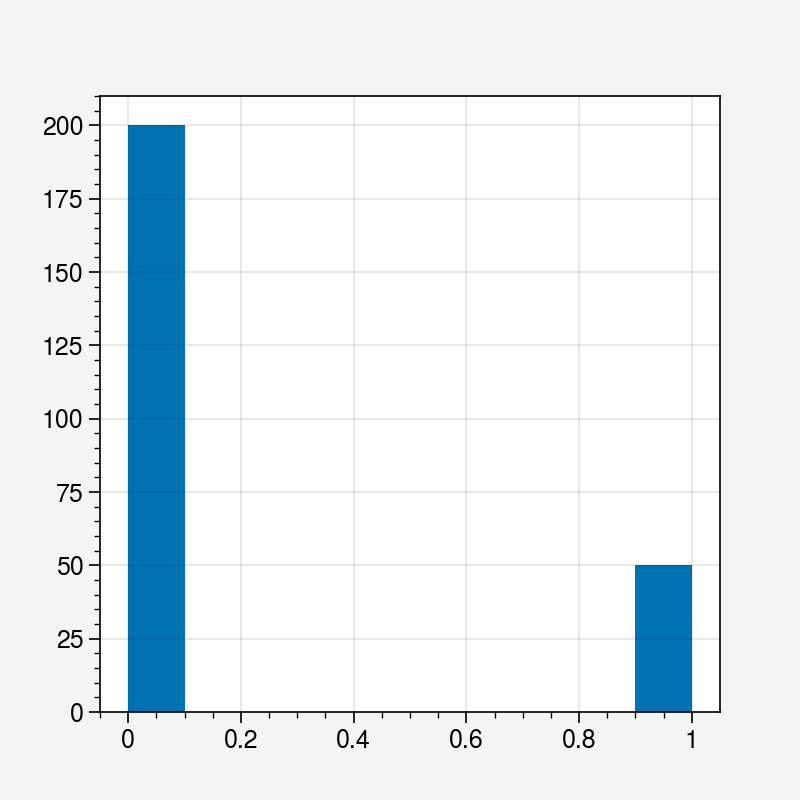

60
cvd quantiles: 0.51, 0.63, 0.73, 0.82
60
60
60


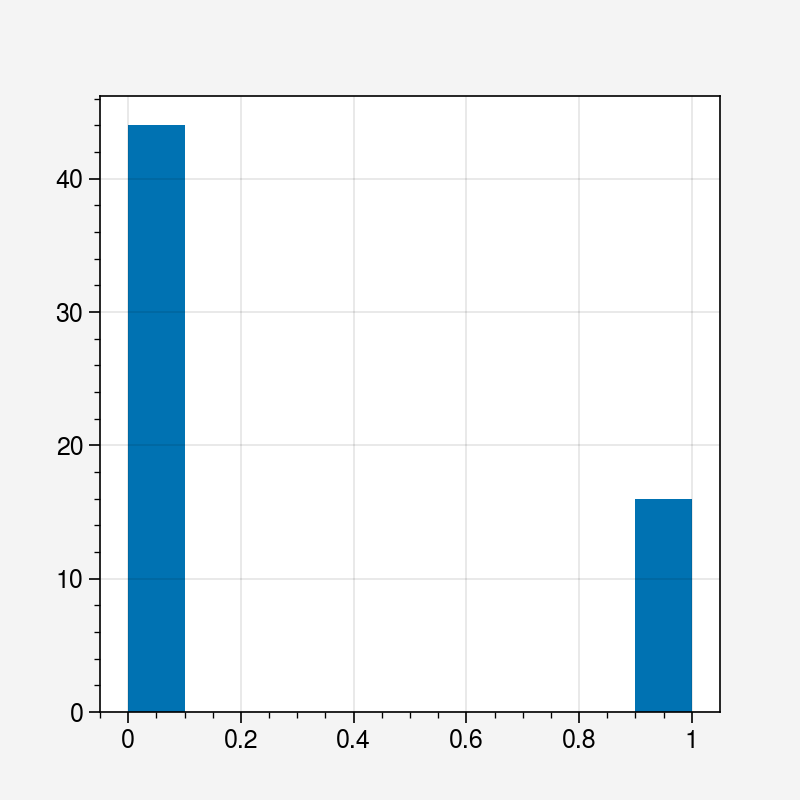

cvd quantiles: 0.55, 0.66, 0.74, 0.81


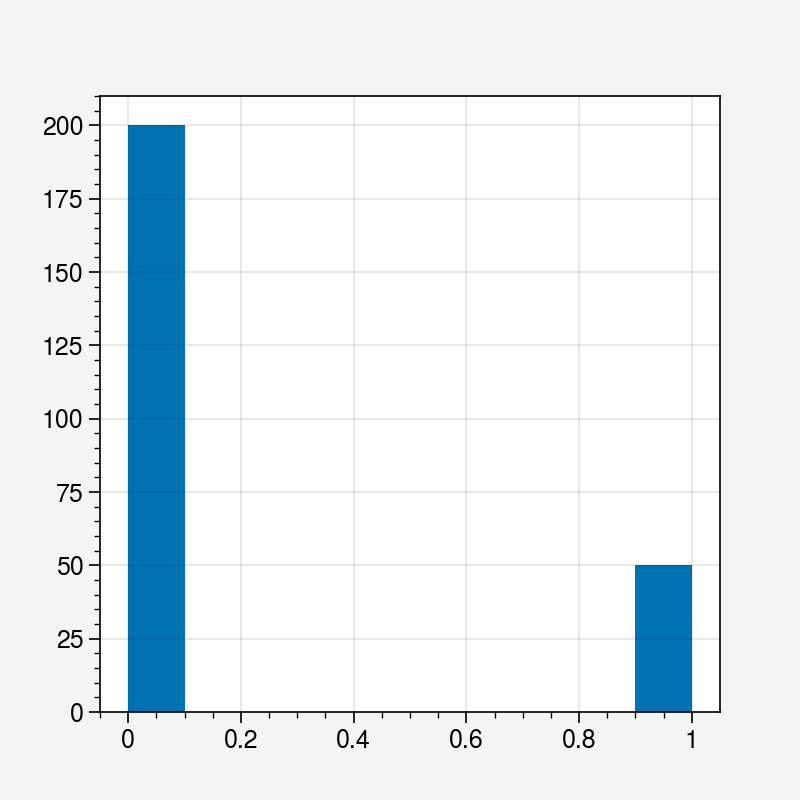

60
cvd quantiles: 0.48, 0.58, 0.73, 0.80
60
60
60


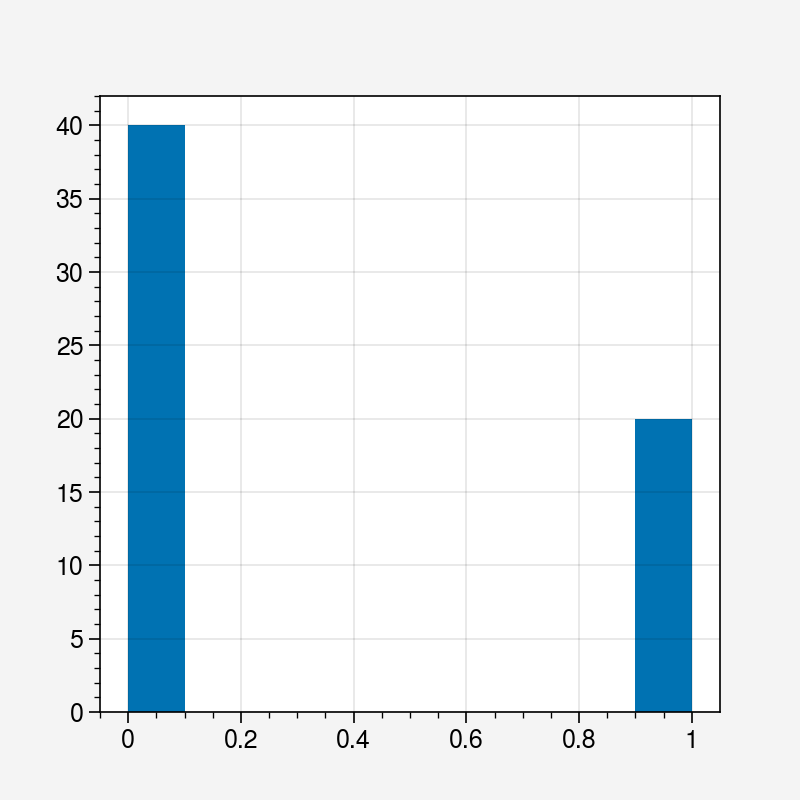

cvd quantiles: 0.52, 0.63, 0.72, 0.80


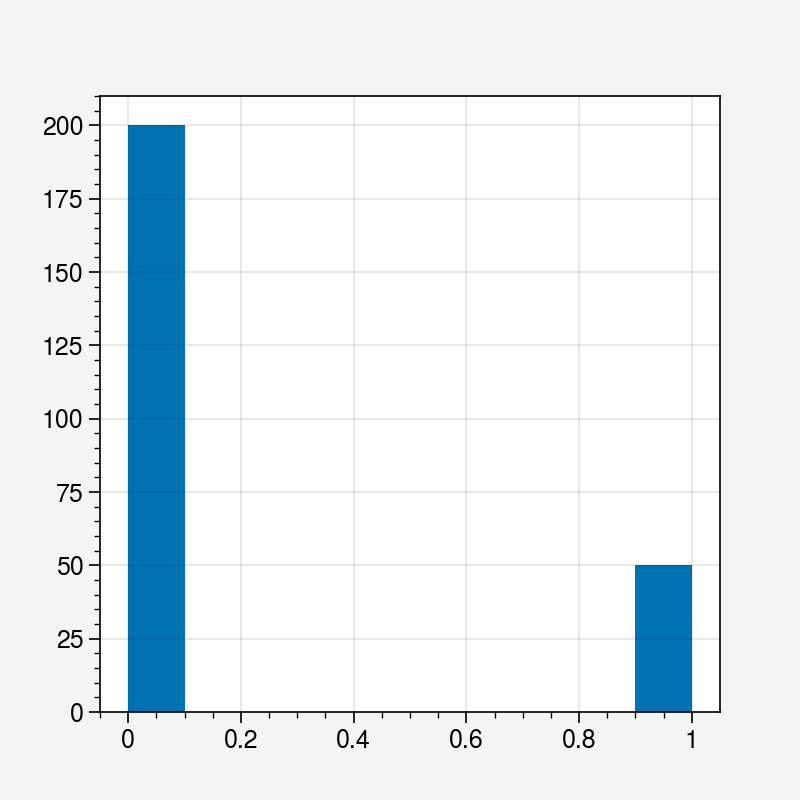

60
cvd quantiles: 0.44, 0.60, 0.70, 0.78
60
60
60


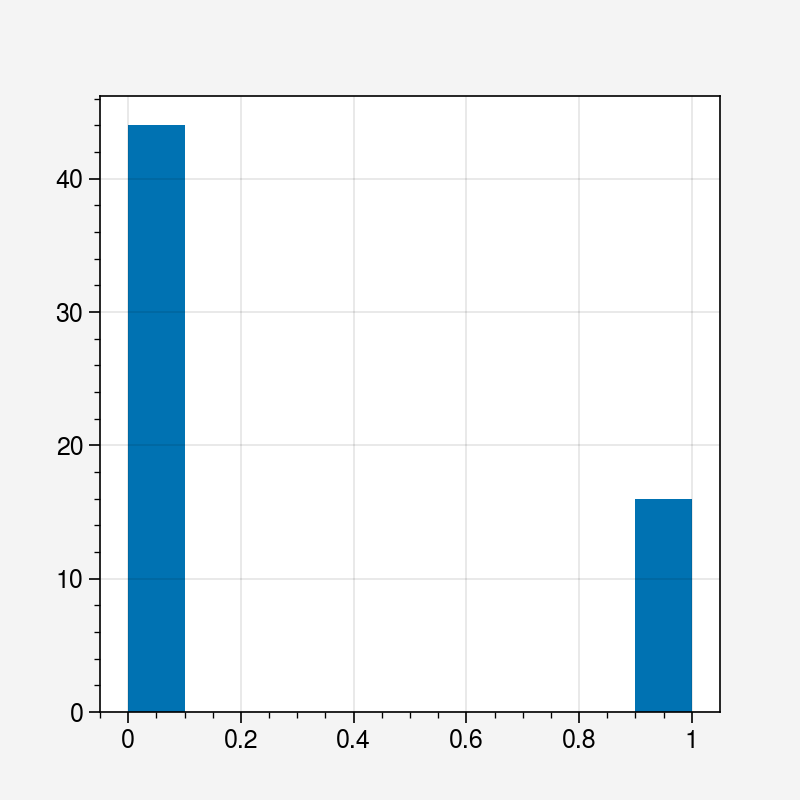

In [21]:
for model in ['ssn_ens', 'punet', 'deterministic']:
    avd = cvd_sdata[model]['dice']
    print(f"cvd quantiles: {np.quantile(avd, 0.2):.2f}, {np.quantile(avd, 0.4):.2f}, {np.quantile(avd, 0.6):.2f}, {np.quantile(avd, 0.8):.2f}", )

    cvd_avd_class = np.zeros(len(avd))
    cvd_avd_class[avd > np.quantile(avd, 0.2)] = 0
    cvd_avd_class[avd <= np.quantile(avd, 0.2)] = 1
    # cvd_avd_class[avd < np.quantile(avd, 0.2)] = 0
    # cvd_avd_class[(avd >= np.quantile(avd, 0.2)) * (avd < np.quantile(avd, 0.4))] = 1
    # cvd_avd_class[(avd >= np.quantile(avd, 0.4)) * (avd < np.quantile(avd, 0.6))] = 2
    # cvd_avd_class[(avd >= np.quantile(avd, 0.6)) * (avd < np.quantile(avd, 0.8))] = 3
    # cvd_avd_class[avd >= np.quantile(avd, 0.8)] = 4
    
    for model_ in ['ssn_ens', 'punet', 'deterministic']:
        cvd_sdata[model_][f'avd_class_{model}'] = cvd_avd_class
        # cvd_sdata[model_][f'avd_{model}'] = avd
    plt.hist(cvd_avd_class);
    plt.show()
    
    
    # challenge_sdata[model] = challenge_sdata[model].dropna(subset='avd')
    avd = challenge_sdata[model]['dice']
    print(len(avd))
    # avd = avd[~np.isnan(avd)]
    print(f"cvd quantiles: {np.quantile(avd, 0.2):.2f}, {np.quantile(avd, 0.4):.2f}, {np.quantile(avd, 0.6):.2f}, {np.quantile(avd, 0.8):.2f}", )

    
    cvd_avd = cvd_sdata[model]['dice']
    chal_avd_class = np.zeros(len(avd))
    chal_avd_class[avd > np.quantile(cvd_avd, 0.2)] = 0
    chal_avd_class[avd <= np.quantile(cvd_avd, 0.2)] = 1
    # chal_avd_class[avd < np.quantile(cvd_avd, 0.2)] = 0
    # chal_avd_class[(avd >= np.quantile(cvd_avd, 0.2)) * (avd < np.quantile(cvd_avd, 0.4))] = 1
    # chal_avd_class[(avd >= np.quantile(cvd_avd, 0.4)) * (avd < np.quantile(cvd_avd, 0.6))] = 2
    # chal_avd_class[(avd >= np.quantile(cvd_avd, 0.6)) * (avd < np.quantile(cvd_avd, 0.8))] = 3
    # chal_avd_class[avd >= np.quantile(cvd_avd, 0.8)] = 4
    
    for model_ in ['ssn_ens', 'punet', 'deterministic']:
        print(len(chal_avd_class))
        challenge_sdata[model_][f'avd_class_{model}'] = chal_avd_class
        # challenge_sdata[model_][f'avd_{model}'] = avd
    plt.hist(chal_avd_class);
    plt.show()

### training the baseline model

In [22]:
from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, QuantileTransformer

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE

In [25]:
import scipy
import scipy.stats as stats
from scipy.stats import ttest_rel

In [26]:
feature_rules_vol_only = {
    "avd_class_ssn_ens":{
        'excludes':['deep', 'pv', 'ring4', '_caudate'] + ['region'],
        'uq_fields':[],
    },
    "avd_class_deterministic":{
        'excludes':['deep', 'pv', 'ring4', '_caudate'] + ['region'],
        'uq_fields':[],
    },
    "avd_class_punet":{
        'excludes':['deep', 'pv', 'ring4', '_caudate'] + ['region'],
        'uq_fields':[],
    }
}

uq_fields = ['vd_std', 'umap_atseg'] # ['vd_std', 'umap_raw', 'umap_atseg']
excludes = ['deep', 'pv', 'caudate', 'ring4', '_cc_'] # 

feature_rules_region_standard = {
    "avd_class_ssn_ens":{
        'excludes':excludes,
        'uq_fields':[],
    },
    "avd_class_deterministic":{
        'excludes':excludes,
        'uq_fields':[],
    },
    "avd_class_punet":{
        'excludes':excludes,
        'uq_fields':[],
    },
}

feature_rules_uq5 = {
    "avd_class_ssn_ens":{
        'excludes':excludes,
        'uq_fields':uq_fields,
    },
    "avd_class_deterministic":{
        'excludes':excludes,
        'uq_fields':uq_fields,
    },
    "avd_class_punet":{
        'excludes':excludes,
        'uq_fields':uq_fields,
    }
}


uq_rules = feature_rules_uq5

In [27]:
def run_across_folds(target, t, k):
    results_sets = defaultdict(lambda : {})
    selected_folds = ['cvd', 'challenge']
    for model_name_f in ['vol', 'deterministic',  'ssn_ens', 'ssn_ens_umap', 'punet', 'punet_umap']:
            
        if "_umap" in model_name_f:
            rules = uq_rules
        elif model_name_f == "vol":
            rules = feature_rules_vol_only
        else:
            rules = feature_rules_region_standard
            
        if model_name_f == 'vol':
            model_name = "deterministic"
        elif "_umap" in model_name_f:
            model_name = model_name_f[:-5]
        else:
            model_name = model_name_f
        
        for holdout in ['challenge']:
            # print("heldout df: ", holdout)

            ds = get_data_splits(model_name=model_name, target=target, t=t, selected_folds=selected_folds, holdout=holdout, rules=rules,
                                cut=True, log_condition='vd_')

            
            if model_name_f == "vol":
                clf = LogisticRegression(class_weight='balanced', C=1, max_iter=5000, random_state=5)
            else:
                clf = RFE(LogisticRegression(class_weight='balanced', C=0.1, max_iter=5000, random_state=5), n_features_to_select=k, step=0.05)
            clf.fit(pd.concat([ds['X_train'], ds['X_cal']]), np.concatenate([ds['y_train'], ds['y_cal']]))


            outputs = {'train':{},
                       'cal':{},
                       'test':{},
                       'holdout':{},
                      }

            for fold in ['test', 'holdout']:
                outputs[fold]['pred'] = clf.predict(ds[f'X_{fold}'])
                outputs[fold]['pred_proba'] = clf.predict_proba(ds[f'X_{fold}'])
                outputs[fold]['y'] = ds[f'y_{fold}']

            results_per_run = {'test':{}, 'holdout':{}}

            for fold in ['test', 'holdout']:
                acc = accuracy_score(outputs[fold]['y'], outputs[fold]['pred'])
                bal_acc = balanced_accuracy_score(outputs[fold]['y'], outputs[fold]['pred'])
                f1 = f1_score(outputs[fold]['y'], outputs[fold]['pred'], average='binary')

                results_per_run[fold] = {'acc':acc, 'bal_acc':bal_acc, 'f1':f1, 'y':outputs[fold]['y'], 'pred':outputs[fold]['pred'], 'pred_proba':outputs[fold]['pred_proba']}

            results_sets[model_name_f][holdout] = results_per_run
    return results_sets

experiment_run_results = defaultdict(lambda : defaultdict(lambda : {}))

targets = ['avd_class_deterministic']#, 'avd_class_deterministic', 'avd_class_punet']
ks = [6, 7, 8, 9, 10, 11, 12]
# ks = [10, 11, 12, 13, 14, 15, 16]
for t in [0.1, 0.2, 0.3]:
    for k in ks:#, 21, 22, 23, 24, 25]:
        for target in targets:
            print(t, k)
            experiment_run_results[target][t][k] = run_across_folds(target, t, k)
        
print("done")


0.1 6
0.1 7
0.1 8


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.1 9


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.1 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.1 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.1 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.2 6
0.2 7
0.2 8


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.2 9


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.2 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.2 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.2 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.3 6
0.3 7
0.3 8


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.3 9


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=9 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.3 10


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.3 11


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=11 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


0.3 12


/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/s2208943/miniconda3/envs/wmh/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=12 > n_features=7. There will be no feature selection and all features will be kept.
  warnings.warn(


done


In [28]:
import statsmodels
from statsmodels.stats.contingency_tables import SquareTable
from sklearn.metrics import cohen_kappa_score, roc_auc_score

In [29]:
def rmbs_score(y_true, y_pred_proba, n_classes=4):
    y_onehot = (y.reshape(-1, 1) == np.array(list(range(n_classes)))).astype(np.float32)
    rmbs = np.sqrt(
                np.mean(
                    np.sum((y_pred_proba - y_onehot) ** 2, axis=1)
                )
            )
    return rmbs
        

In [30]:
t = 0.2
k = 9
holdout="challenge"

stats_results = {
    "target":[],
    "model":[],
    "kappa":[],
    "kappa_ci":[],
    "sm_statistic":[],
    "sm_pvalue":[],
    "bal_acc":[],
    "bal_acc_ci":[],
    "f1":[],
    "f1_ci":[],
    "roc_auc_score":[],
    "roc_auc_score_ci":[],
    "rbs": [],
    "rbs_ci":[],
}

for target in experiment_run_results.keys():
    # print("TARGET: ", target)

    for model in experiment_run_results[target][0.2][9].keys():
        y = np.concatenate([
            experiment_run_results[target][0.2][9][model][holdout]['holdout']['y'],
            experiment_run_results[target][0.2][9][model][holdout]['test']['y'],
        ])
        pred = np.concatenate([
            experiment_run_results[target][0.2][9][model][holdout]['holdout']['pred'],
            experiment_run_results[target][0.2][9][model][holdout]['test']['pred'],
        ])
        pred_proba = np.concatenate([
            experiment_run_results[target][0.2][9][model][holdout]['holdout']['pred_proba'],
            experiment_run_results[target][0.2][9][model][holdout]['test']['pred_proba'],
        ])
        kappa = cohen_kappa_score(y, pred)
        t = SquareTable(pd.crosstab(y, pred))
        # print(pd.crosstab(y, pred))
        sm = t.homogeneity('stuart_maxwell').__dict__
        # print(f"{model}: {kappa:.2f} sm statistic: {sm['statistic']:.2f} sm pvalue: {sm['pvalue']:.2}")
        stats_results['target'].append(target)
        stats_results['model'].append(model)
        stats_results['kappa'].append(kappa)
        stats_results['sm_statistic'].append(sm['statistic'])
        stats_results['sm_pvalue'].append(sm['pvalue'])
        stats_results['bal_acc'].append(balanced_accuracy_score(y, pred))
        stats_results['f1'].append(f1_score(y, pred, average='macro'))
        # print(y.shape)
        # print(pred_proba.shape)
        stats_results['roc_auc_score'].append(roc_auc_score(y, pred_proba[:,1]))
        stats_results['rbs'].append(rmbs_score(y, pred_proba, n_classes=2))
        
        n_iterations = 1000
        btst_bal_acc = []
        btst_f1 = []
        btst_rocauc_macro = []
        btst_rbs = []
        btst_kappa = []
        for _ in tqdm(range(n_iterations), ncols=100):
            indices = np.random.choice(range(len(y)), size=len(y), replace=True)
            y_btst = y[indices]
            pred_btst = pred[indices]
            pred_proba_btst = pred_proba[indices]
            btst_bal_acc.append(balanced_accuracy_score(y_btst, pred_btst))
            btst_f1.append(f1_score(y_btst, pred_btst, average='micro'))
            btst_rocauc_macro.append(roc_auc_score(y_btst, pred_proba_btst[:,1]))
            btst_rbs.append(rmbs_score(y_btst, pred_proba_btst, n_classes=2))
            btst_kappa.append(cohen_kappa_score(y_btst, pred_btst))
                            
        bal_acc_ci = 1.96 * np.std(btst_bal_acc)
        f1_ci = 1.96 * np.std(btst_f1)
        rocauc_ci = 1.96 * np.std(btst_rocauc_macro)
        rbs_ci = 1.96 * np.std(btst_rbs)
        kappa_ci = 1.96 * np.std(btst_kappa)
        
        stats_results['bal_acc_ci'].append(bal_acc_ci)
        stats_results['f1_ci'].append(f1_ci)  
        stats_results['roc_auc_score_ci'].append(rocauc_ci) 
        stats_results['rbs_ci'].append(rbs_ci) 
        stats_results['kappa_ci'].append(kappa_ci) 
        
    # print("------------------------------")
stats_results = pd.DataFrame(stats_results)

100%|██████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 134.07it/s]


In [31]:
pd.set_option('display.float_format',
      lambda x: '{:,.2f}'.format(x) if abs(x) < 2 else '{:,.2}'.format(x))

In [32]:
# with cal fold
stats_results

,target,model,kappa,kappa_ci,sm_statistic,sm_pvalue,bal_acc,bal_acc_ci,f1,f1_ci,roc_auc_score,roc_auc_score_ci,rbs,rbs_ci
0,avd_class_deterministic,vol,0.33,0.19,3.6,0.06,0.69,0.11,0.66,0.08,0.79,0.10,0.58,0.07
1,avd_class_deterministic,deterministic,0.45,0.19,3.5,0.06,0.75,0.10,0.72,0.08,0.83,0.10,0.54,0.07
2,avd_class_deterministic,ssn_ens,0.45,0.19,3.5,0.06,0.75,0.10,0.72,0.08,0.84,0.10,0.53,0.07
3,avd_class_deterministic,ssn_ens_umap,0.56,0.19,0.00,1.00,0.78,0.10,0.78,0.07,0.86,0.09,0.49,0.08
4,avd_class_deterministic,punet,0.48,0.20,2.3,0.13,0.76,0.10,0.74,0.08,0.83,0.10,0.53,0.07
5,avd_class_deterministic,punet_umap,0.54,0.19,0.89,0.35,0.78,0.10,0.77,0.08,0.85,0.10,0.51,0.08


In [33]:
stats_results_copy = stats_results.copy()
stats_results_copy['model'] = [{'vol':'1. Volume Only', 'deterministic':'2. SEnt', 'ssn_ens':'5. SSN Ens', 'ssn_ens_umap':'6. SSN Ens w/ UQ', 'punet':'3. P-Unet', 'punet_umap':'4. P-Unet w/ UQ'}[n] for n in stats_results_copy['model'].values]

float_formatter = lambda x: '{:,.2f}'.format(x) if abs(x) < 2 else '{:,.2}'.format(x)

stats_results_latex = {
    'Method':[],
    'Kappa':[],
    'Bal. Acc':[],
    'AUROC':[],
    'RBS':[],
}

for _, row in stats_results_copy.iterrows():
    stats_results_latex['Method'].append(row['model'])
    stats_results_latex['Kappa'].append(f"{float_formatter(row['kappa'])} $\pm$ {float_formatter(row['kappa_ci'])}")
    stats_results_latex['Bal. Acc'].append(f"{float_formatter(row['bal_acc'])} $\pm$ {float_formatter(row['bal_acc_ci'])}")
    stats_results_latex['AUROC'].append(f"{float_formatter(row['roc_auc_score'])} $\pm$ {float_formatter(row['roc_auc_score_ci'])}")
    stats_results_latex['RBS'].append(f"{float_formatter(row['rbs'])} $\pm$ {float_formatter(row['rbs_ci'])}")
        
stats_results_latex = pd.DataFrame(stats_results_latex)
stats_results_latex = stats_results_latex.set_index('Method')
stats_results_latex = stats_results_latex.sort_index()


In [34]:
stats_results_latex

,Kappa,Bal. Acc,AUROC,RBS
Method,,,,
1. Volume Only,0.33 $\pm$ 0.19,0.69 $\pm$ 0.11,0.79 $\pm$ 0.10,0.58 $\pm$ 0.07
2. SEnt,0.45 $\pm$ 0.19,0.75 $\pm$ 0.10,0.83 $\pm$ 0.10,0.54 $\pm$ 0.07
3. P-Unet,0.48 $\pm$ 0.20,0.76 $\pm$ 0.10,0.83 $\pm$ 0.10,0.53 $\pm$ 0.07
4. P-Unet w/ UQ,0.54 $\pm$ 0.19,0.78 $\pm$ 0.10,0.85 $\pm$ 0.10,0.51 $\pm$ 0.08
5. SSN Ens,0.45 $\pm$ 0.19,0.75 $\pm$ 0.10,0.84 $\pm$ 0.10,0.53 $\pm$ 0.07
6. SSN Ens w/ UQ,0.56 $\pm$ 0.19,0.78 $\pm$ 0.10,0.86 $\pm$ 0.09,0.49 $\pm$ 0.08


In [35]:
print(stats_results_latex.to_latex())

\begin{tabular}{lllll}
\toprule
 & Kappa & Bal. Acc & AUROC & RBS \\
Method &  &  &  &  \\
\midrule
1. Volume Only & 0.33 $\pm$ 0.19 & 0.69 $\pm$ 0.11 & 0.79 $\pm$ 0.10 & 0.58 $\pm$ 0.07 \\
2. SEnt & 0.45 $\pm$ 0.19 & 0.75 $\pm$ 0.10 & 0.83 $\pm$ 0.10 & 0.54 $\pm$ 0.07 \\
3. P-Unet & 0.48 $\pm$ 0.20 & 0.76 $\pm$ 0.10 & 0.83 $\pm$ 0.10 & 0.53 $\pm$ 0.07 \\
4. P-Unet w/ UQ & 0.54 $\pm$ 0.19 & 0.78 $\pm$ 0.10 & 0.85 $\pm$ 0.10 & 0.51 $\pm$ 0.08 \\
5. SSN Ens & 0.45 $\pm$ 0.19 & 0.75 $\pm$ 0.10 & 0.84 $\pm$ 0.10 & 0.53 $\pm$ 0.07 \\
6. SSN Ens w/ UQ & 0.56 $\pm$ 0.19 & 0.78 $\pm$ 0.10 & 0.86 $\pm$ 0.09 & 0.49 $\pm$ 0.08 \\
\bottomrule
\end{tabular}



In [39]:
all_param_results = {
    'k':[],
    't':[],
    'bal_acc':[],
    'rbs':[],
    'model_name':[],
}

target = 'avd_class_deterministic'

for model in experiment_run_results[target][0.2][9].keys():
    for t in [0.1, 0.2, 0.3]:
        for k in ks:
            y = np.concatenate([
                experiment_run_results[target][t][k][model][holdout]['holdout']['y'],
                experiment_run_results[target][t][k][model][holdout]['test']['y'],
            ])
            pred = np.concatenate([
                experiment_run_results[target][t][k][model][holdout]['holdout']['pred'],
                experiment_run_results[target][t][k][model][holdout]['test']['pred'],
            ])
            pred_proba = np.concatenate([
                experiment_run_results[target][t][k][model][holdout]['holdout']['pred_proba'],
                experiment_run_results[target][t][k][model][holdout]['test']['pred_proba'],
            ])

            all_param_results['bal_acc'].append(balanced_accuracy_score(y, pred))
            all_param_results['rbs'].append(rmbs_score(y, pred_proba, n_classes=2))
            all_param_results['model_name'].append(model)
            all_param_results['k'].append(k)
            all_param_results['t'].append(t)
            
all_param_results = pd.DataFrame(all_param_results)

In [40]:
all_param_results['model_name'] = [{'vol':'1. Volume Only', 'deterministic':'2. SEnt', 'ssn_ens':'5. SSN Ens', 'ssn_ens_umap':'6. SSN Ens w/ UQ', 'punet':'3. P-Unet', 'punet_umap':'4. P-Unet w/ UQ'}[n] for n in all_param_results['model_name'].values]


In [41]:
all_param_results

,k,t,bal_acc,rbs,model_name
0,6,0.10,0.69,0.59,1. Volume Only
1,7,0.10,0.69,0.59,1. Volume Only
2,8,0.10,0.69,0.59,1. Volume Only
3,9,0.10,0.69,0.59,1. Volume Only
4,10,0.10,0.69,0.59,1. Volume Only
...,...,...,...,...,...
121,8,0.30,0.79,0.52,4. P-Unet w/ UQ
122,9,0.30,0.79,0.52,4. P-Unet w/ UQ
123,10,0.30,0.79,0.52,4. P-Unet w/ UQ
124,11,0.30,0.79,0.52,4. P-Unet w/ UQ


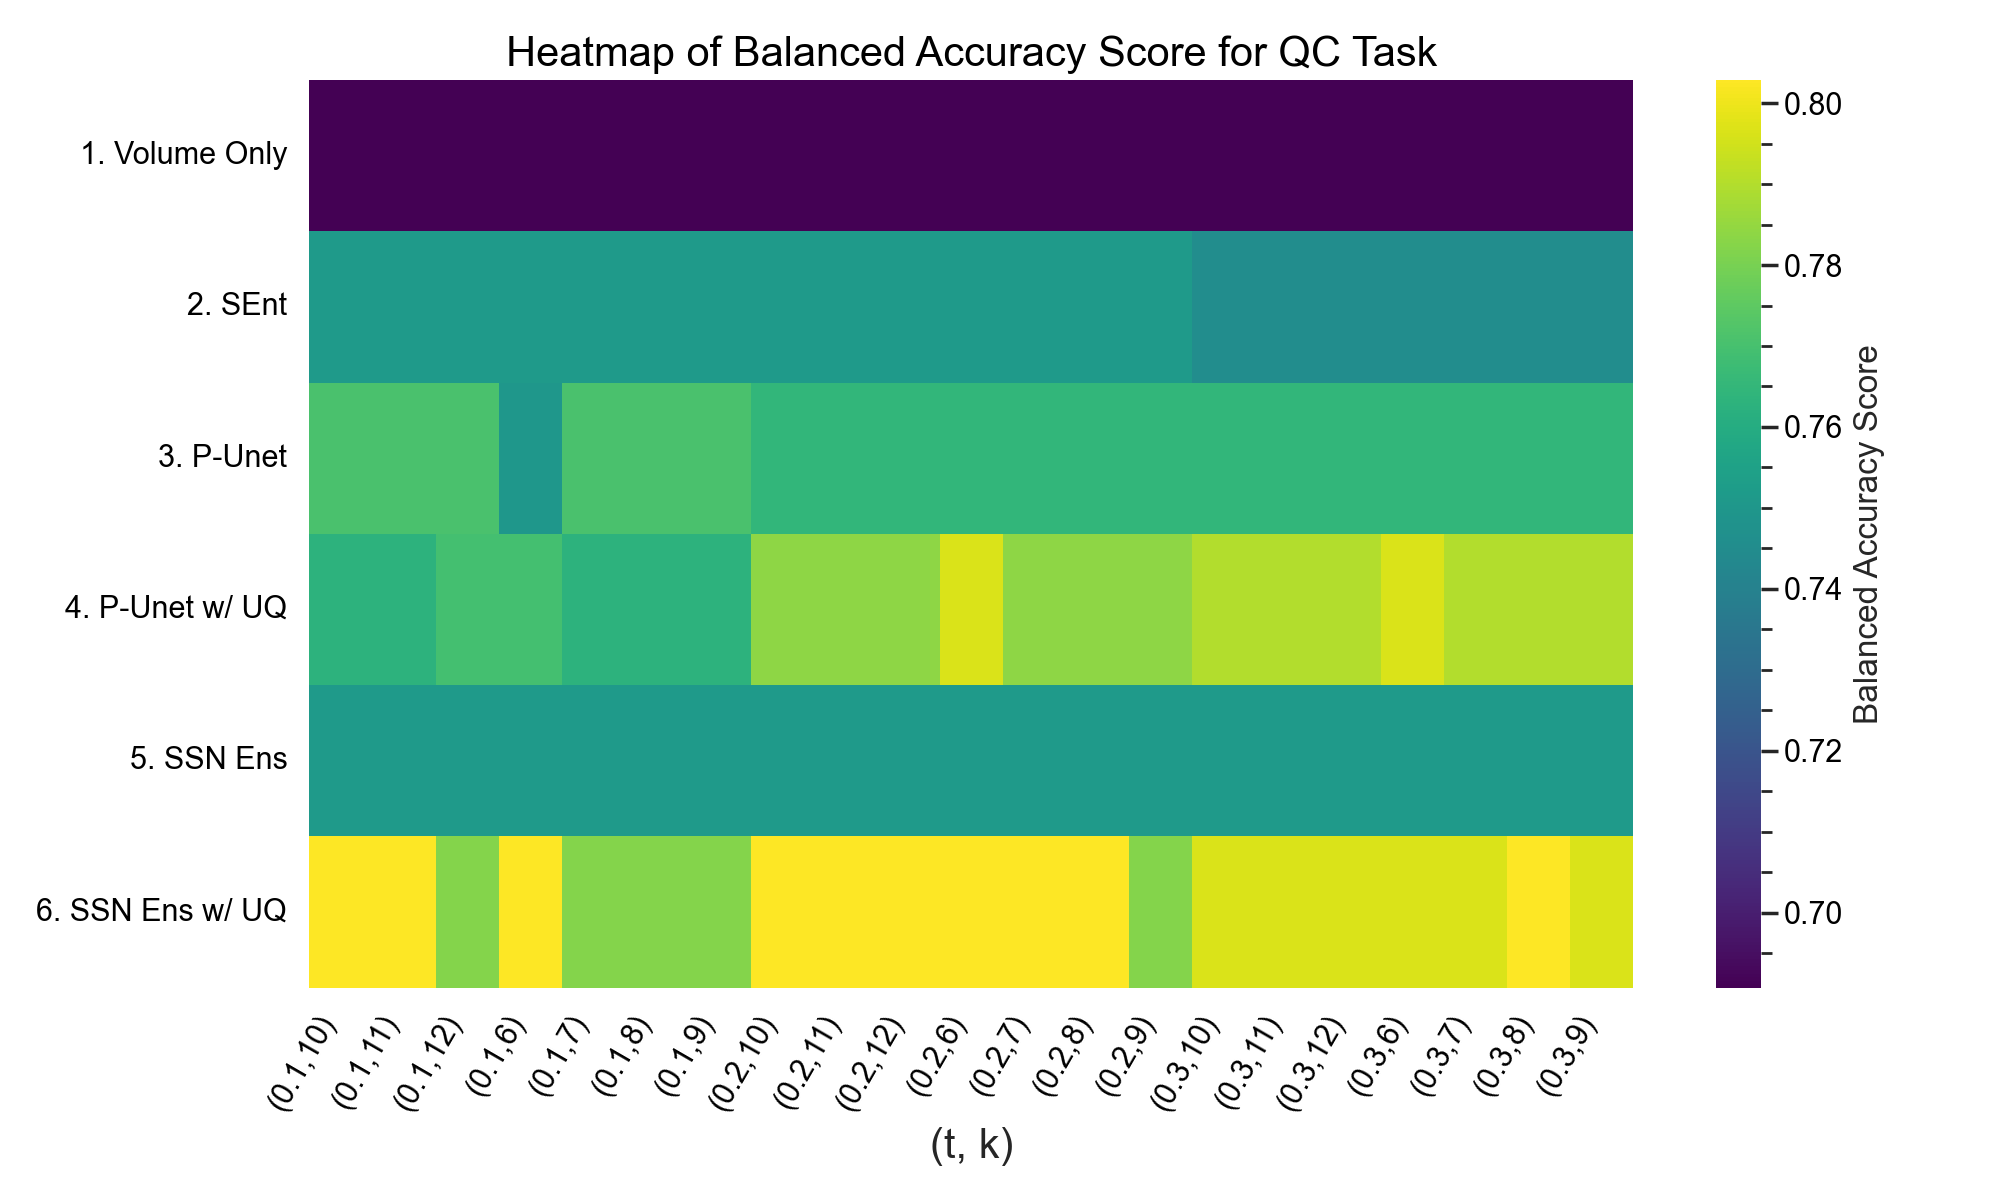

In [42]:
df = all_param_results.copy()
metric = 'bal_acc'
metric_name = "Balanced Accuracy Score"

# Sort the dataframe by k and t
df['k_t'] = df.apply(lambda row: f"({row['t']},{row['k']})", axis=1)
df = df.sort_values(by=['k', 't'])

# Create heatmaps for each target


fontsize=15
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'xtick.bottom': False, 'ytick.left': False})


heatmap_data = df.pivot(index='model_name', columns='k_t', values=metric)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=False, cmap='viridis', cbar_kws={'label': metric_name})
plt.title(f"Heatmap of {metric_name} for QC Task", fontsize=fontsize)
plt.xlabel("(t, k)", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.savefig(f"hparam_heatmap_QC_dice_{metric}.pdf")
plt.show()

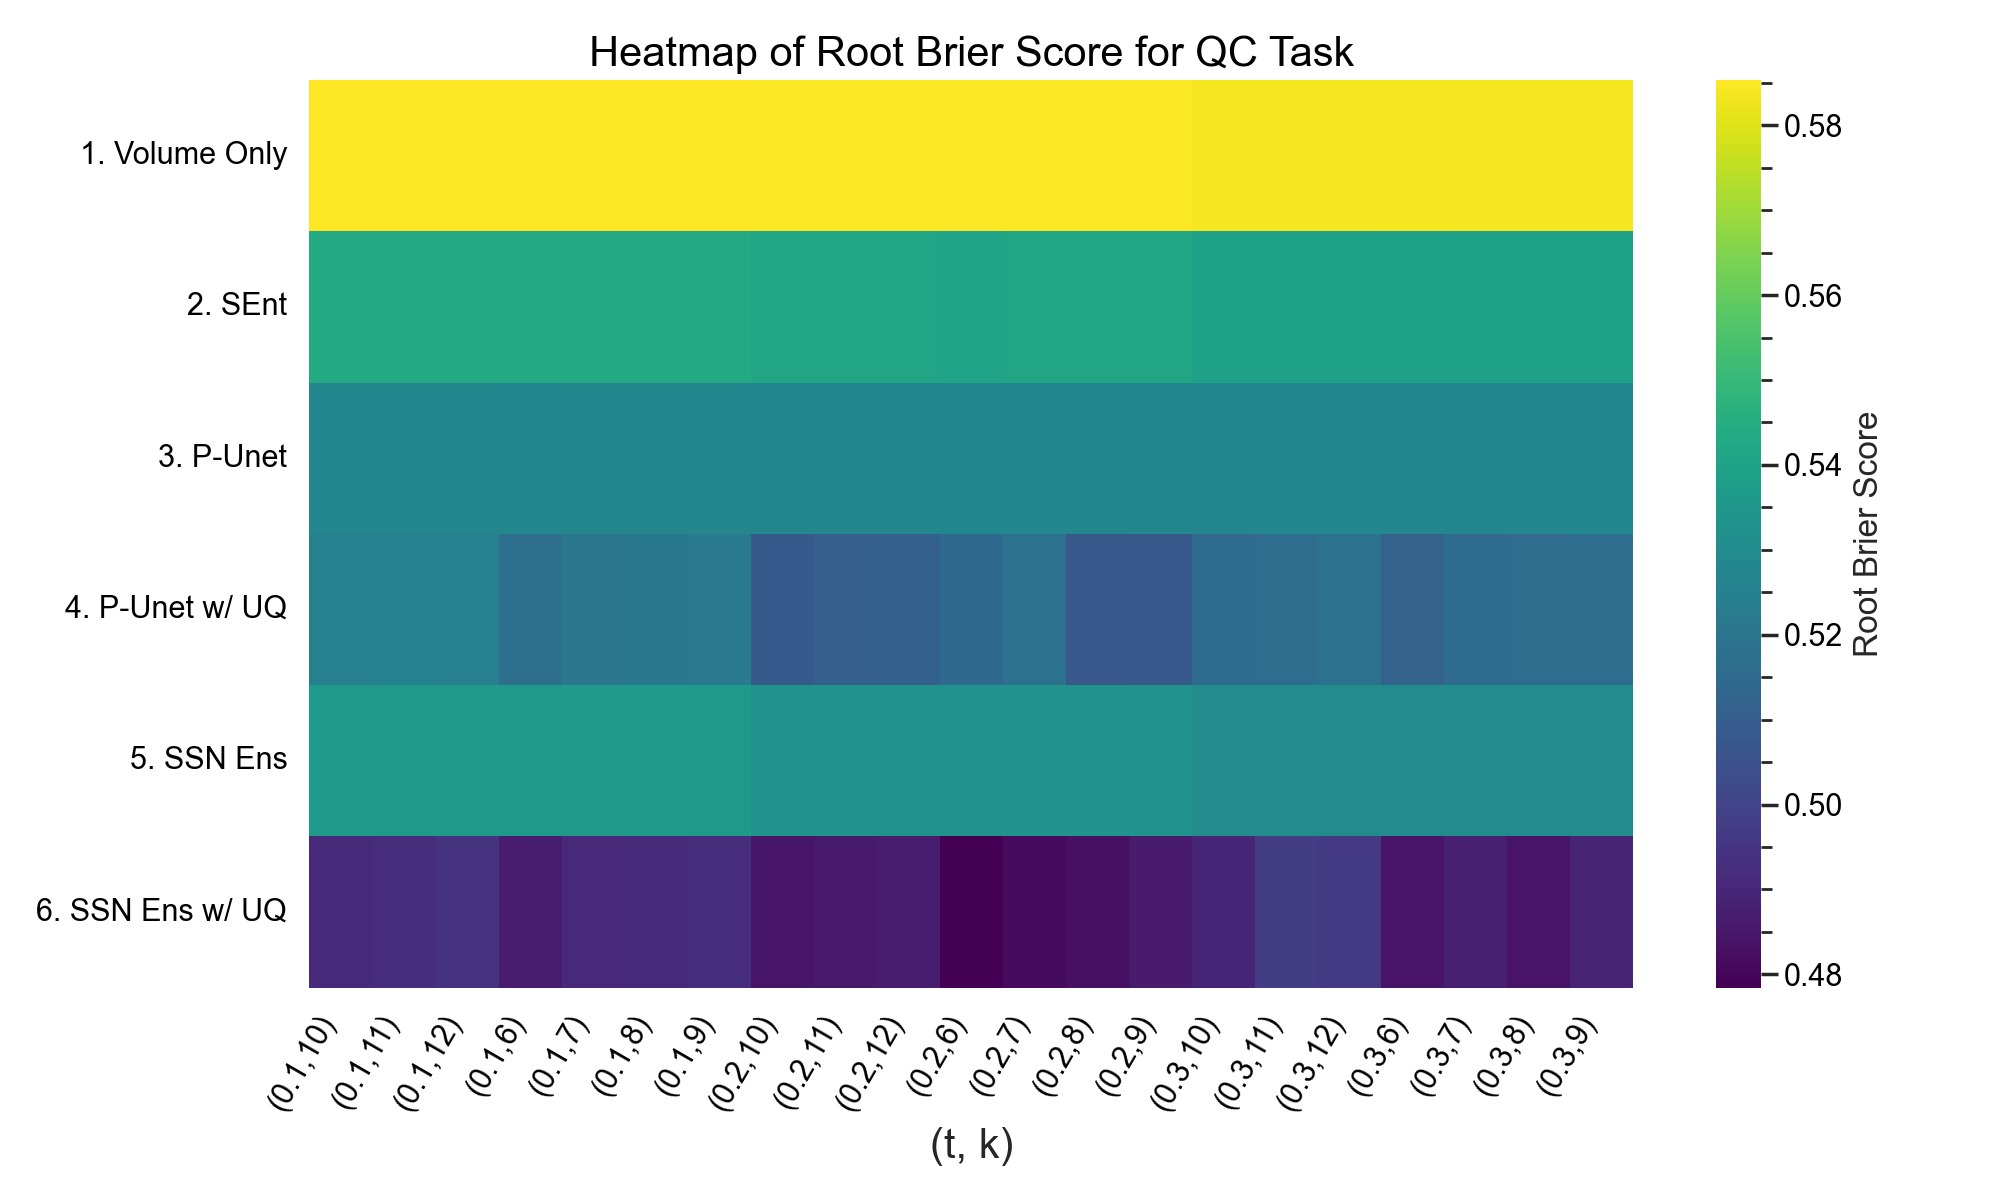

In [43]:
df = all_param_results.copy()
metric = 'rbs'
metric_name = "Root Brier Score"

# Sort the dataframe by k and t
df['k_t'] = df.apply(lambda row: f"({row['t']},{row['k']})", axis=1)
df = df.sort_values(by=['k', 't'])

# Create heatmaps for each target


fontsize=15
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'xtick.bottom': False, 'ytick.left': False})


heatmap_data = df.pivot(index='model_name', columns='k_t', values=metric)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=False, cmap='viridis', cbar_kws={'label': metric_name})
plt.title(f"Heatmap of {metric_name} for QC Task", fontsize=fontsize)
plt.xlabel("(t, k)", fontsize=fontsize)
plt.ylabel("", fontsize=fontsize)
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.savefig(f"hparam_heatmap_QC_dice_{metric}.pdf")
plt.show()